# Load Dependencies and Configuration Settings

In [2]:
import pandas as pd
import numpy as np
import datetime 
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline

# Load and View the Dataset

In [3]:
cs_df = pd.read_csv("Online Retail.csv")

In [4]:
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
cs_df.shape

(541909, 8)

# Top Sales by Country

In [6]:
cs_df.Country.value_counts().reset_index().head(10)

,index,Country
0,United Kingdom,495478
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,2002
8,Portugal,1519
9,Australia,1259


# Top Customers contributing to 10% of total Sales

In [7]:
cs_df.CustomerID.unique().shape

(4373,)

In [8]:
(cs_df.CustomerID.value_counts()/sum(cs_df.CustomerID.value_counts())*100).head(n=13).cumsum()

17841.0    1.962249
14911.0    3.413228
14096.0    4.673708
12748.0    5.814728
14606.0    6.498553
15311.0    7.110850
14646.0    7.623350
13089.0    8.079807
13263.0    8.492020
14298.0    8.895138
15039.0    9.265809
14156.0    9.614850
18118.0    9.930462
Name: CustomerID, dtype: float64

# Analyzing Data Quality Issues

Number of unique items

In [9]:
cs_df.StockCode.unique().shape

(4070,)

In [10]:
cs_df.Description.unique().shape

(4224,)

Description of items: We see that the descriptions are more then the stock code so there must be some stock code which have more than one decription

In [11]:
cs_df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [12]:
cat_des_df = cs_df.groupby(['StockCode','Description']).count().reset_index()
cat_des_df.head()

,StockCode,Description,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,10002,INFLATABLE POLITICAL GLOBE,71,71,71,71,49,71
1,10080,GROOVY CACTUS INFLATABLE,22,22,22,22,21,22
2,10080,check,1,1,1,1,0,1
3,10120,DOGGY RUBBER,30,30,30,30,30,30
4,10123C,HEARTS WRAPPING TAPE,3,3,3,3,3,3


Stockcode which have more than one description

In [13]:
cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head()

,index,StockCode
0,20713,8
1,23084,7
2,85175,6
3,21830,6
4,23131,5


Example of one such stockcode

In [14]:
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
     .reset_index()['index'][5]]['Description'].unique()

array(['JUMBO BAG VINTAGE CHRISTMAS ', 'came coded as 20713',
       'wrongly coded 20713', '20713 wrongly marked', '20713'],
      dtype=object)

In [15]:
cs_df['invdatetime'] = pd.to_datetime(cs_df.InvoiceDate)

In [16]:
cs_df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [17]:
cs_df.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

# Data Cleaning

In [18]:
# Seperate data for one geography
cs_df = cs_df[cs_df.Country == 'United Kingdom']

# Seperate attribute for total amount
cs_df['amount'] = cs_df.Quantity * cs_df.UnitPrice

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.amount<0)]
cs_df.head()
cs_df = cs_df[~(cs_df.CustomerID.isnull())]

In [19]:
cs_df.shape

(354345, 10)

# Build Recency Feature

In [20]:
cs_df.invdatetime.max()

Timestamp('2011-12-09 12:49:00')

In [21]:
cs_df.invdatetime.min()

Timestamp('2010-12-01 08:26:00')

In [22]:
refrence_date = cs_df.invdatetime.max()
refrence_date = refrence_date + datetime.timedelta(days=1)

In [23]:
cs_df['days_since_last_purchase'] = refrence_date - cs_df.invdatetime
cs_df['days_since_last_purchase_num'] = cs_df['days_since_last_purchase'].astype('timedelta64[D]')

Time period of transactions

In [26]:
customer_history_df = cs_df.groupby("CustomerID").min().reset_index()[['CustomerID', 'days_since_last_purchase_num']]
customer_history_df.rename(columns={'days_since_last_purchase_num':'recency'}, inplace=True)
customer_history_df.recency.describe()

count    3921.000000
mean       92.188472
std        99.528995
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: recency, dtype: float64

In [27]:
customer_history_df.head()

,CustomerID,recency
0,12346.0,326.0
1,12747.0,2.0
2,12748.0,1.0
3,12749.0,4.0
4,12820.0,3.0


### Visual plot of recency

AttributeError: module 'matplotlib.mlab' has no attribute 'normpdf'

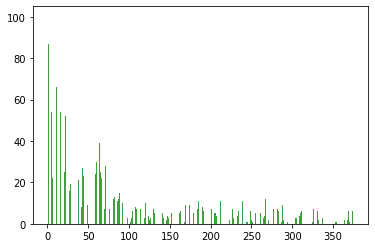

In [30]:
x = customer_history_df.recency
mu = np.mean(customer_history_df.recency)
sigma = np.sqrt(np.var(customer_history_df.recency))
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
# add a best fit line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of \sales\ recency}\ $')

# Build Frequency & Monetary value Features

In [34]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val, how='outer')
customer_history_df.amount = customer_history_df.amount+0.001
customer_freq = cs_df[['CustomerID', 'amount']].groupby("CustomerID").count().reset_index()
customer_freq.rename(columns={'amount':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq, how='outer')

Remove returns so that we only have purchases of a customer

In [35]:
customer_history_df.head()

,CustomerID,recency,amount,frequency
0,12346.0,326.0,77183.601,1
1,12747.0,2.0,4196.011,103
2,12748.0,1.0,33719.731,4596
3,12749.0,4.0,4090.881,199
4,12820.0,3.0,942.341,59


### Preprocessing

In [36]:
from sklearn import preprocessing
import math

In [42]:
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
feature_vector = ['amount_log', 'recency_log', 'frequency_log']
X_subset = customer_history_df[feature_vector].values
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)

# Visualizing Recency vs Monetary Value (scaled)

Text(0, 0.5, 'Amount log')

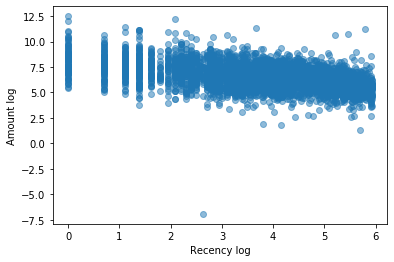

In [44]:
plt.scatter(customer_history_df.recency_log, customer_history_df.amount_log, alpha=0.5)
plt.xlabel("Recency log")
plt.ylabel("Amount log")

# Visualizing Monetary Value distribution (scaled)

Text(0.5, 1.0, '$\\mathrm{Histogram\\ of\\ Log\\ Transformed\\ Customer\\ Monetary\\ value}\\ $')

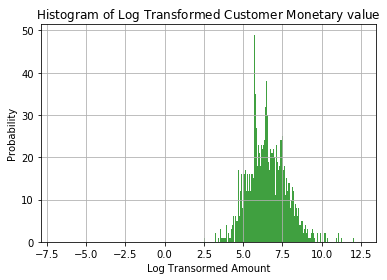

In [51]:
x = customer_history_df.amount_log
n, bins, patches = plt.hist(x,1000, facecolor='green', alpha=0.75)

plt.xlabel("Log Transormed Amount")
plt.ylabel("Probability")
plt.grid(True)
plt.title(r'$\mathrm{Histogram\ of\ Log\ Transformed\ Customer\ Monetary\ value}\ $')

In [52]:
customer_history_df.head()

,CustomerID,recency,amount,frequency,amount_log,recency_log,frequency_log
0,12346.0,326.0,77183.601,1,11.253942,5.786897,0.000000
1,12747.0,2.0,4196.011,103,8.341890,0.693147,4.634729
2,12748.0,1.0,33719.731,4596,10.425838,0.000000,8.432942
3,12749.0,4.0,4090.881,199,8.316516,1.386294,5.293305
4,12820.0,3.0,942.341,59,6.848367,1.098612,4.077537


### 3D Visualization

Text(0.5, 0, 'Monetary')

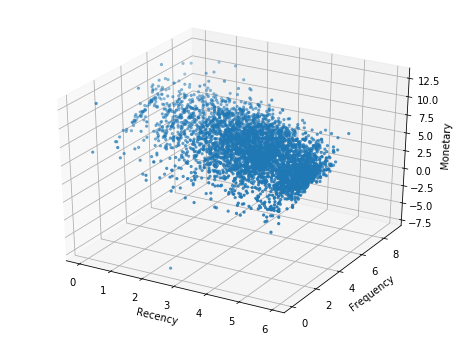

In [56]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

xs = customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Analyze Customer Segments with Clustering

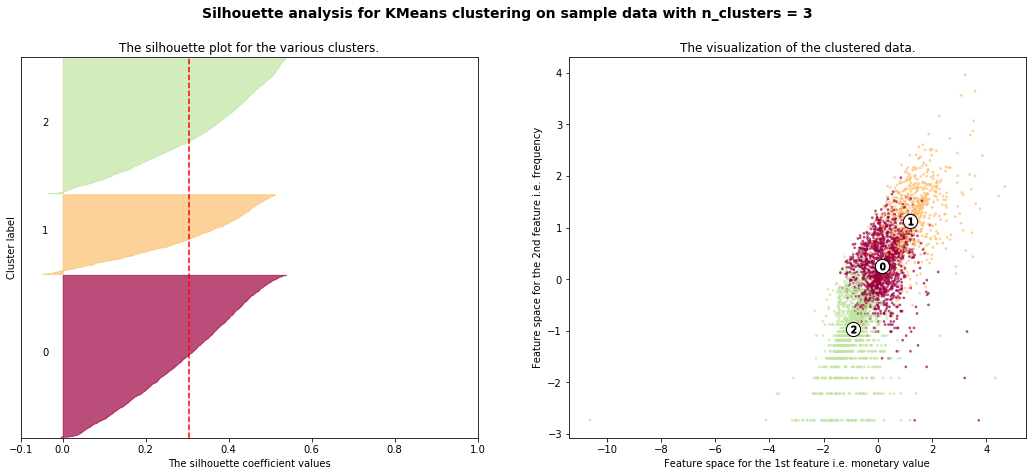

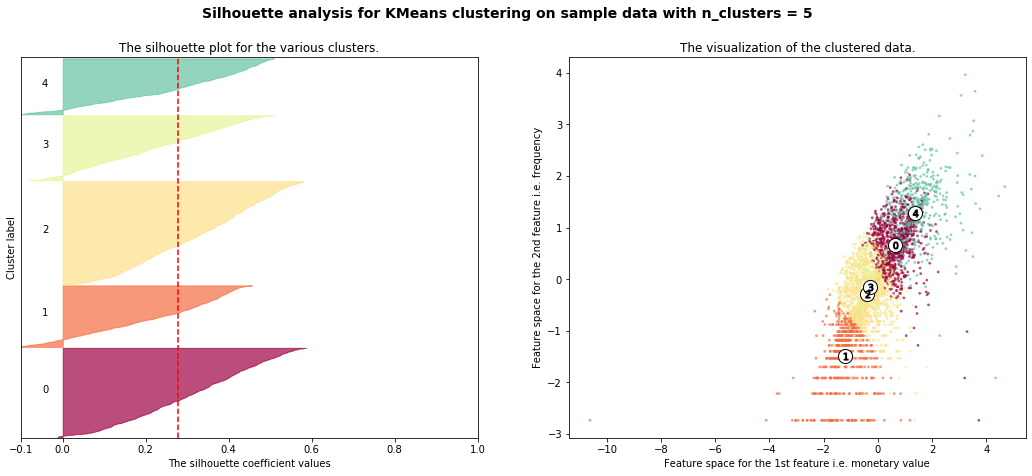

In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = X_scaled

cluster_centers = dict()

for n_clusters in range(3,6,2):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(18,7)
    ax1.set_xlim([0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1)*10])
    
    clusterer = KMeans(n_clusters = n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters:{
        'cluster_center': clusterer.cluster_centers_,
        'silhouette_score': silhouette_avg,
        'labels':cluster_labels
    }})
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.show()

In [66]:
for i in range(3,6,2):
    print("Informaton for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed), columns = feature_vector))
    print("Silhouette score for cluster {} is {}".format(i, cluster_centers[i]['silhouette_score']))
    print()

Informaton for 3 number of clusters
    amount_log  recency_log  frequency_log
0   847.948147    43.919979      54.168353
1  3176.613711     7.105747     178.619263
2   221.345334   121.718136      10.674492
Silhouette score for cluster 3 is 0.3049143490754894

Informaton for 5 number of clusters
    amount_log  recency_log  frequency_log
0  1556.264976    46.931474      95.202084
1   147.234837   122.514737       5.350229
2   418.127351   137.914525      26.398616
3   487.181819    13.231693      31.546739
4  3996.868450     5.543104     217.304588
Silhouette score for cluster 5 is 0.2778046607348517



# Assign Cluster Labels

In [68]:
labels = cluster_centers[5]['labels']
customer_history_df['num_clusters_5_labels'] = labels
labels = cluster_centers[3]['labels']
customer_history_df['num_clusters_3_labels'] = labels
customer_history_df.head()

,CustomerID,recency,amount,frequency,amount_log,recency_log,frequency_log,num_clusters_5_labels,num_clusters_3_labels
0,12346.0,326.0,77183.601,1,11.253942,5.786897,0.000000,0,0
1,12747.0,2.0,4196.011,103,8.341890,0.693147,4.634729,4,1
2,12748.0,1.0,33719.731,4596,10.425838,0.000000,8.432942,4,1
3,12749.0,4.0,4090.881,199,8.316516,1.386294,5.293305,4,1
4,12820.0,3.0,942.341,59,6.848367,1.098612,4.077537,3,1


# Visualize Segments

In [69]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

x_data = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5']
cutoff_quantile = 100
field_to_plot = 'recency'

y0 = customer_history_df[customer_history_df['num_cluster5_labels']==0][field_to_plot].values
y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
y1 = customer_history_df[customer_history_df['num_cluster5_labels']==1][field_to_plot].values
y1 = y1[y1<np.percentile(y1, cutoff_quantile)]
y2 = customer_history_df[customer_history_df['num_cluster5_labels']==2][field_to_plot].values
y2 = y2[y2<np.percentile(y2, cutoff_quantile)]
y3 = customer_history_df[customer_history_df['num_cluster5_labels']==3][field_to_plot].values
y3 = y3[y3<np.percentile(y3, cutoff_quantile)]
y4 = customer_history_df[customer_history_df['num_cluster5_labels']==4][field_to_plot].values
y4 = y4[y4<np.percentile(y4, cutoff_quantile)]
y_data = [y0,y1,y2,y3,y4]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints=False,
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Difference in sales {} from cluster to cluster'.format(field_to_plot),
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=50,
        gridcolor='black',
        gridwidth=0.1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
py.offline.iplot(fig)

ModuleNotFoundError: No module named 'plotly'

#### Do the same for all (Recency, Frequency, Amount) with different cutoff_quantile (eg. 80, 100)